In [1]:
1+1

2

In [ ]:
include("cosmology.jl")
using PyPlot, ODE, Dierckx, Roots
set_bigfloat_precision(64);

In [11]:
rg(m) = 2.0.*m.*G./C./C
function mnfw(ρ0, rs, r)
    if r>200.0
        r=200.0
    end
    rrs = rs+r
    (log(rrs./rs)-r./rrs)*4.0*π*ρ0*rs*rs*rs
end
rgnfw(ρ0, rs, r) = rg(mnfw(ρ0, rs, r))
rhonfw(ρ0, rs, r) = mnfw(ρ0, rs, r) ./ vsphere(r)
vsphere(r) = 4/3*pi.*r.*r.*r
function mproj(rs,r)
    x = r/rs
    if x>1.0
        log(x./2.0)+2.0./sqrt(abs(1.0-x.*x))*atan(sqrt(abs( (x-1.0)./(x+1.0)  )))
    else
        log(x./2.0)+2.0./sqrt(abs(1.0-x.*x))*atanh(sqrt(abs( (x-1.0)./(x+1.0)  )))
    end
end
function proj_mnfw(ρ0, rs, r)
    f = 200.0./mproj(rs,200.0)
    mproj(rs,r).*f
end
function ρnfw(ρ0, rs, r)
    x = r./rs
    ρ0./(x.*(1.0+x).^2)
end

function thin_lens(frg, r0, rmin_sim, endy=0.0, N=100)
    const tgθ = rmin_sim/r0
    const y0 = r0*tgθ
    const θ=atan(tgθ)
    const nθ = θ-2.0*frg(y0)/y0
    const tgnθ = tan(nθ)
    const nx = (endy-y0)/tgnθ
    
    lx = linspace(big"0.0",big"1.0",div(N,2)).^3
    x = [-reverse(lx)*r0; lx*nx]
    y = zeros(length(x))
    for i in 1:length(x)
        y[i] = if x[i]<0.0
            tgθ*x[i]+y0
        else
            y[i] = y0+tgnθ*x[i]
        end
    end
    x = [(xx) for xx in x]
    y = [(yy) for yy in y]        
    x, y
end

function direct_lens(frg, r0, rmin_sim, endy=0.0, N=100)
    tx, ty = thin_lens(frg, r0, rmin_sim, endy, N)
    ϕf = π-atan(ty[end]/tx[end])
    function f(ϕ, y)
        (u, v) = y
        u_prime = v
        v_prime = 3/2*frg(1/u)*u*u-u
        [u_prime; v_prime]    
    end
    const u0 = 1.0/r0
    const tgθ = rmin_sim/r0
    const du0 = 1.0/(r0*abs(tgθ))
    start = [u0; du0];
    ϕl=linspace(0,ϕf,N)
    
    ϕ, y = ode78(f, start, ϕl, abstol=1.0e-14, reltol=1.0e-16);
    u = map(y -> y[1], y);
    x = [(v) for v in -cos(ϕ)./u]
    y = [(v) for v in sin(ϕ)./u]        
    spl = Spline1D(x,y, k=5, bc="extrapolate")
    
    t = (endy-y[end-100])/(y[end]-y[end-100])
    xmax = x[end-100]+t*(x[end]-x[end-100])
    
    #xmax = fzero(xx->evaluate(spl,xx)-endy, x[end]; order=8)    
    lx = linspace(big"0.0",big"1.0",div(N,2)).^3
    x = [-reverse(lx)*r0; lx*xmax]
    y = evaluate(spl, x)

    x,y
end

function opt_target(frg, fn, tx, ty, r0, rsim_min, fac, M=10)
    display("!!!!!!!!!!!!!!!!!!!!!!!!!!")
    iter = 0
    x = zeros(100000)
    y = zeros(100000)
    positive=false
    while true
        iter += 1
        iter>5000 && error("maximum iterations reached!")
        x,y = fn(frg, r0, rsim_min, ty, 100000);

        dx = tx-x[end]
        if iter % M == 0
            display(string(dx)*", "*string(fac)*", "*string(rsim_min))
        end
        if dx>0.0000000001
            rsim_min +=fac
            if positive
                fac*=0.995
            else
                fac *= 0.5
            end
            positive=true
            continue
        end
        if dx<-0.0000000001
            rsim_min -=fac
            if !positive
                fac*=0.995
            else
                fac *= 0.5
            end
            positive=false
            continue
        end
        break
    end
    rsim_min, fac, x, y
end
    
function opt(frg, dy, r0, u_rsim_min, N=10000)
    dux,duy = direct_lens(frg, r0, u_rsim_min, dy, 100000);
    tx = dux[end]
    ty = dy
    
    fac = 0.2
    rsim_min, fac, tux, tuy = opt_target(frg, thin_lens, tx, ty, r0, u_rsim_min, fac)
    @show rsim_min
    rsim_min, fac, tdx, tdy = opt_target(frg, thin_lens, tx, -ty, r0, rsim_min, 0.05)
    @show rsim_min
    tdy = -tdy
    rsim_min, fac, ddx, ddy = opt_target(frg, direct_lens, tx, -ty, r0, rsim_min, 0.03, 1)
    @show rsim_min

    ddy = -ddy
    
    tdx,tdy,tux,tuy, ddx,ddy,dux,duy 
end

opt (generic function with 2 methods)

In [12]:
r200mw = 200.0;
cmw = 20;
rsmw = r200mw/cmw;
ρ0mw = 0.007607;
mmw = mnfw(ρ0mw, rsmw, r200mw)
_rg(r) = rgnfw(ρ0mw, rsmw, r);

In [13]:
function mfac(ρ0, rs, rmax, rp, N)
    tot = zeros(N)
    ptot = zeros(N)
    @inbounds for i in 1:N
        x=rand()*rp+1.0e-3
        y=rand()*rp+1.0e-3
        z=rand()*rmax+1.0e-3
        r=sqrt(x*x+y*y+z*z)
        r>rmax && continue
        pr = sqrt(x*x+y*y)
        pr > rp && continue
        ρ=ρnfw(ρ0, rs, r)        
        ptot[i] = ρ
        if r <= rp
            tot[i] = ρ
        end
    end
    sum(ptot)/sum(tot)
end

mfac (generic function with 1 method)

In [14]:
mfac(ρ0mw, rsmw, 200.0, 4.0, 50000000)

1.9686105617167717

In [15]:
rmin_sim = big"4.0"
r0 = big"2.7e6"
endy = big"-1.0"
tosmall(x) = [Float64(xi) for xi in x]

tosmall (generic function with 1 method)

In [16]:
r0 = big"2.7e6"
r200mw = big"200.0";
cmw = big"20.0";
rsmw = r200mw/cmw;
ρ0mw = big"0.007607";
mmw = mnfw(ρ0mw, rsmw, r200mw)
_rg(r) = rgnfw(ρ0mw, rsmw, r);
dx,dy = direct_lens(_rg, r0, rmin_sim, endy, 100000);

In [17]:
ρ0mw = big"0.007607"*1.97;
_rgg(r) = rgnfw(ρ0mw, rsmw, r);
tx,ty = thin_lens(_rgg, r0, rmin_sim, endy, 100000);

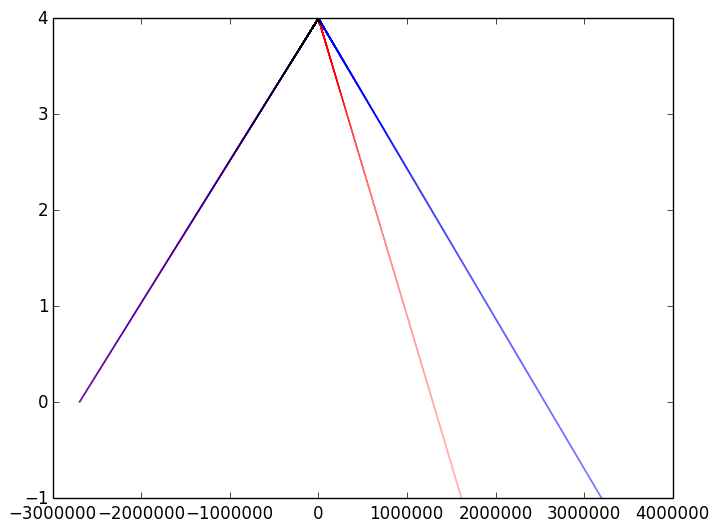

In [18]:
hold(false)
plot(tosmall(dx), tosmall(dy), ".b", ms=0.02, lw=1.1)
hold(true)
plot(tosmall(tx), tosmall(ty), ".r", ms=0.01, lw=0.01)
hold(false)

In [8]:
dx[end]

3.50647620452741222084e+06

In [9]:
dx[end-100]

3.4854789778588080826e+06

In [ ]:
dtx,dty,utx,uty, ddx,ddy,udx,udy = opt(_rg, endy, r0, rmin_sim, big"100000"); # setup1
#opt(frg, dy, r0, u_rsim_min, N=10000)

"!!!!!!!!!!!!!!!!!!!!!!!!!!"

"-1.19931985348037103927e+06, 0.19117791567151193, 2.73558313430238755903"

"-1.29984458611041741119e+06, 0.18183125231650604, 8.66250463301211415246e-01"

"5.38416352359724494818e+05, 0.04367100480126935, -2.10969726987208734681e-01"

"4.25162782904329105804e+03, 0.00016888822862647142, -1.84366246459053598477e-01"

"-1.7906244212224464718, 1.2997464898686933e-6, -1.8418122122439958477e-01"

"-8.27885388703407443245e-01, 1.9905404265373383e-8, -1.84181263062010452407e-01"

"-4.86738236395467538387e-03, 1.5318995014482151e-10, -1.841812988277999888e-01"

"3.93325121876841876656e-05, 1.1789341483606741e-12, -1.8418129904103052675e-01"

"-5.20532466907752677798e-07, 1.805518307477304e-14, -1.84181299039298615369e-01"

"1.83717929758131504059e-10, 2.7651216678799607e-16, -1.8418129903932121952e-01"

"!!!!!!!!!!!!!!!!!!!!!!!!!!"

"3.15130364879914731646e+07, 0.02401732608938592, 6.23534830834943711866e-02"

"8.14874158368777308806e+06, 0.02284312215031483, 2.97194270897712479546e-01"

"5.40743280471187924559e+06, 0.0217263248886315, 5.20553723234378112384e-01"

"4.29509024651905341261e+06, 0.020664127699368054, 7.32993161087067508969e-01"

"3.66387519778462591103e+06, 0.019653861192107325, 9.3504646253921420171e-01"

"3.23937408353486352325e+06, 0.01869298648258137, 1.12722140444440541379"

"2.92267167374962852318e+06, 0.01777908881224288, 1.3100009385121039624"

"2.66943730912685647218e+06, 0.016909871479774866, 1.48384440500570573501"

"2.45687033680480247358e+06, 0.016083150069288107, 1.64918868710305731881"

"2.27206916700050441068e+06, 0.0152968469607012, 1.80644930882043878528"

"2.10720361736667154537e+06, 0.014548986108507463, 1.9560214792591858699"

"1.95726015282105278936e+06, 0.013837688075807236, 2.09828108579923126387"

"1.81889069077875860614e+06, 0.013161165311125675, 2.23358563873554320138"

"1.68978229790796526493e+06, 0.012517717656146331, 2.36227516973141178505"

In [ ]:
1+1

In [10]:
ddy[end]

-94999.99999999748

In [11]:
udy[end]

-94999.99999999255

In [12]:
dty[end]

-95000.0

In [13]:
uty[end]

-95000.0

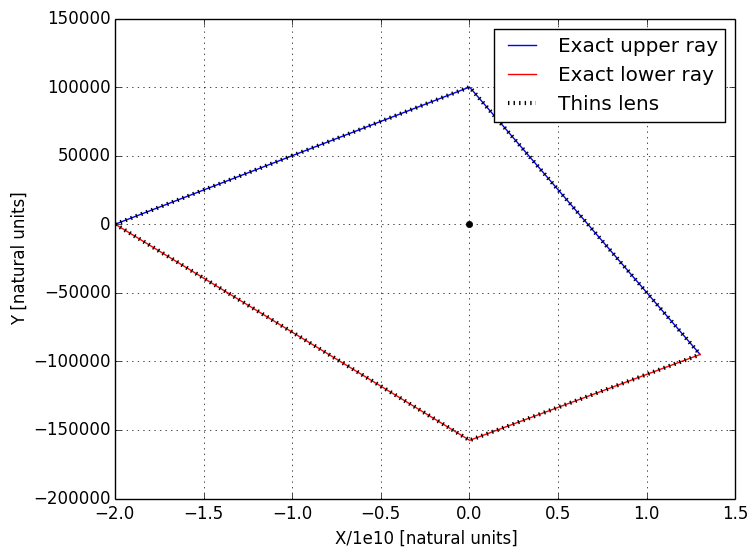

  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
in show at /Users/ariel/.julia/v0.5/PyPlot/src/PyPlot.jl


PyObject <matplotlib.legend.Legend object at 0x3164a6450>

  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35


In [14]:
tosmall(x) = [Float64(xi) for xi in x]
plot(tosmall(udx)/1e10,tosmall(udy),"-b")
hold(true)
plot(tosmall(ddx)/1e10,tosmall(ddy),"-r")
plot(tosmall(utx)/1e10,tosmall(uty),":k", lw=3)
plot(tosmall(dtx)/1e10,tosmall(dty),":k", lw=3)
plot(0,0,"ok",ms=5)
hold(false)
grid(true)
xlabel("X/1e10 [natural units]")
ylabel("Y [natural units]")
legend(["Exact upper ray","Exact lower ray","Thins lens"])
#xlim(-5e-5,5e-5)
#ylim(100062,100072)

In [15]:
function len(x,y)
    tobig(x) = [BigFloat(xi) for xi in x]
    dx = tobig(x[2:end]-x[1:(end-1)])
    dy = tobig(y[2:end]-y[1:(end-1)])
    cx = tobig(0.5*(x[1:(end-1)]+x[2:end]))
    cy = tobig(0.5*(y[1:(end-1)]+y[2:end]))
    cr = sqrt(cx.*cx+cy.*cy)
    dr = sqrt(dx.*dx+dy.*dy)
    gf = 1./sqrt(1.0-1.0./cr)
    l = sum(dr)
    gl = sum(dr.*gf)
    Float64(l), Float64(gl)
end

len (generic function with 1 method)

In [16]:
dd = len(utx,uty)[2] - len(dtx,dty)[2]

1.3943595886230469

In [17]:
dt = len(udx,udy)[2] - len(ddx,ddy)[2]

1.3943634033203125

In [18]:
_d1 = ddx[end]-dtx[end]

-5.80231745388980554247744203574527228223e-11

In [19]:
_d2 = udx[end]-utx[end]

5.738408138201406226821871991773136188541e-11

In [20]:
dt-dd

3.814697265625e-6

In [21]:
_d2-_d1

1.154072559209121176929931402751840847077e-10

In [ ]:
setup 1 - 3.81e-6
setup 2 - 3.81e-6